# Heatmaps

## Affixes most frequent consonants

Given a position in an affix, how often does a consonant appear in that position? 

Frequency is measured based on total number of words an affix that contains the consonant at that position is present.


Consonant Frequency by Position (normalized):
Position 0: [('r', 0.14993290959730085), ('t', 0.13506398632159916), ('n', 0.11800891767404491), ('l', 0.10810447975805204), ('s', 0.08958357610586723)]
Position 1: [('r', 0.13539792828446362), ('t', 0.13244538386200555), ('n', 0.11430787911494873), ('l', 0.09618474046091423), ('s', 0.09185679878475345)]
Position 2: [('t', 0.18083917046838605), ('n', 0.1369086161195087), ('r', 0.1317662545018204), ('l', 0.1089149567808849), ('s', 0.08639151125106757)]
Position 3: [('l', 0.19148378725687124), ('t', 0.1805796414357541), ('h', 0.1278305241226155), ('r', 0.12432472895587189), ('n', 0.10166805983556448)]
Position 4: [('l', 0.28997668997668996), ('p', 0.24545454545454545), ('h', 0.22121212121212122), ('t', 0.21561771561771562), ('c', 0.02773892773892774)]
Position 5: []
Position 6: []
Position 7: []


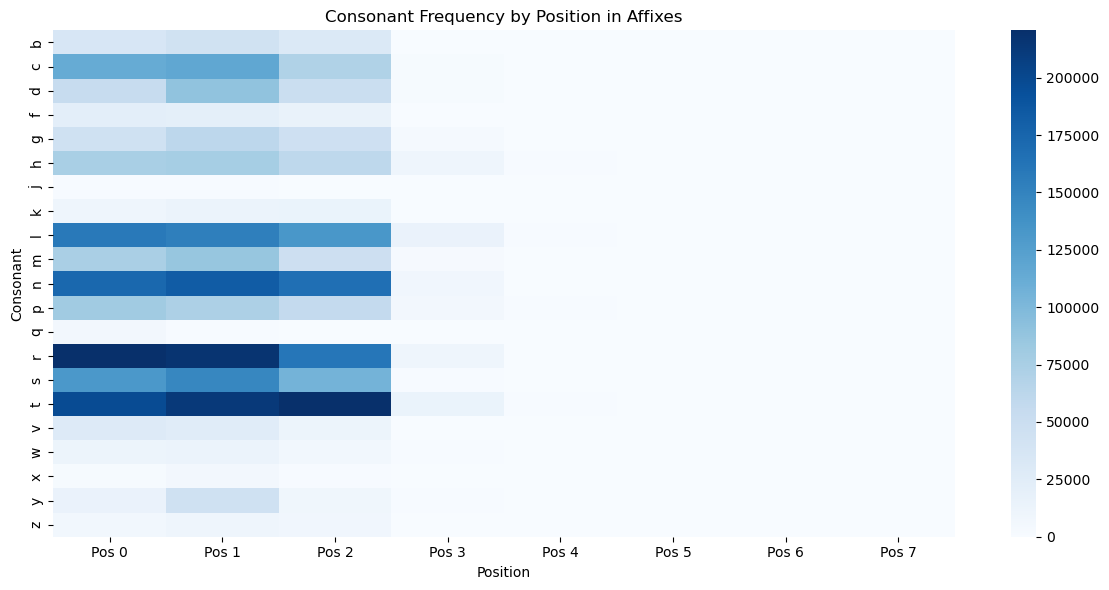

In [10]:
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import string

import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from agents import utils

os.makedirs("heatmaps", exist_ok=True)

# Load affix dictionary (consolidated one)
affix_dict = utils.load_cache(utils.data_path("affixes_train_cons.pkl"))  # or agent.affix_data

# Define consonants and max position to consider
consonants = [c for c in string.ascii_lowercase if c not in 'aeiou']
max_affix_len = 8

# Initialize position-frequency counter
position_consonant_freq = [Counter() for _ in range(max_affix_len)]

# Count consonants by position across affixes
for affix, freq in affix_dict.items():
    for i, char in enumerate(affix):
        if i < max_affix_len and char in consonants:
            position_consonant_freq[i][char] += freq

# Normalize and print table
print("\nConsonant Frequency by Position (normalized):")
for i, counter in enumerate(position_consonant_freq):
    total = sum(counter.values())
    norm = {k: v / total for k, v in counter.items() if total > 0}
    top = sorted(norm.items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"Position {i}: {top}")

# Optional: plot heatmap
import seaborn as sns
import pandas as pd

data = pd.DataFrame({
    c: [position_consonant_freq[i].get(c, 0) for i in range(max_affix_len)]
    for c in consonants
})
data.index = [f"Pos {i}" for i in range(max_affix_len)]
plt.figure(figsize=(12, 6))
sns.heatmap(data.T, cmap="Blues", annot=False)
plt.title("Consonant Frequency by Position in Affixes")
plt.xlabel("Position")
plt.ylabel("Consonant")
plt.tight_layout()
plt.show()
plt.savefig("heatmaps/affix_heatmap.png")
plt.close()


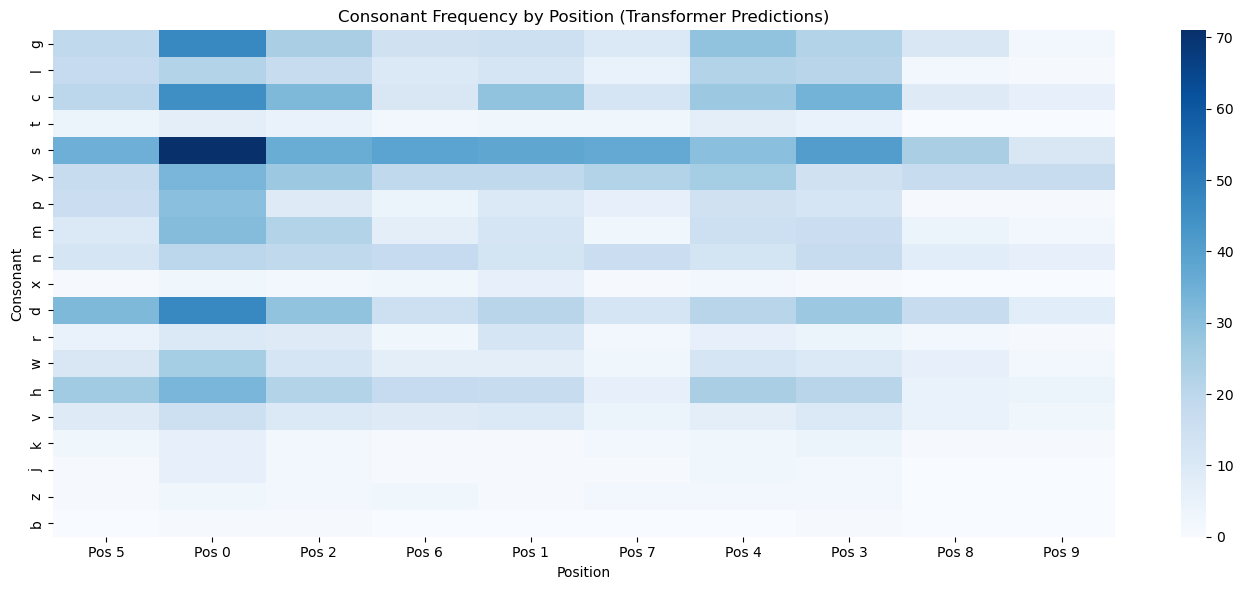

In [11]:
import json
from collections import defaultdict, Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === CONFIG ===
eval_log_path = utils.results_path("logs/v3_eval/transformer_best.jsonl")  # Update path if needed
consonants = set("bcdfghjklmnpqrstvwxyz")

# === STEP 1: Load predictions ===
position_counts = defaultdict(Counter)

with open(eval_log_path, "r") as f:
    for line in f:
        record = json.loads(line)
        pattern = record.get("pattern", "")
        pred_letter = record.get("predicted_letter", "")

        if pred_letter not in consonants:
            continue

        for i, c in enumerate(pattern):
            if c == "_":
                position_counts[i][pred_letter] += 1

# === STEP 2: Build dataframe ===
df = pd.DataFrame(position_counts).fillna(0).astype(int)
df.index.name = "Consonant"
df.columns = [f"Pos {i}" for i in df.columns]

# === STEP 3: Plot heatmap ===
if df.empty:
    print("Warning: No consonant predictions found.")
else:
    plt.figure(figsize=(14, 6))
    sns.heatmap(df, cmap="Blues")
    plt.title("Consonant Frequency by Position (Transformer Predictions)")
    plt.xlabel("Position")
    plt.ylabel("Consonant")
    plt.tight_layout()
    plt.show()
    plt.savefig("heatmaps/transformer_prediction_heatmap.png")
    plt.close()


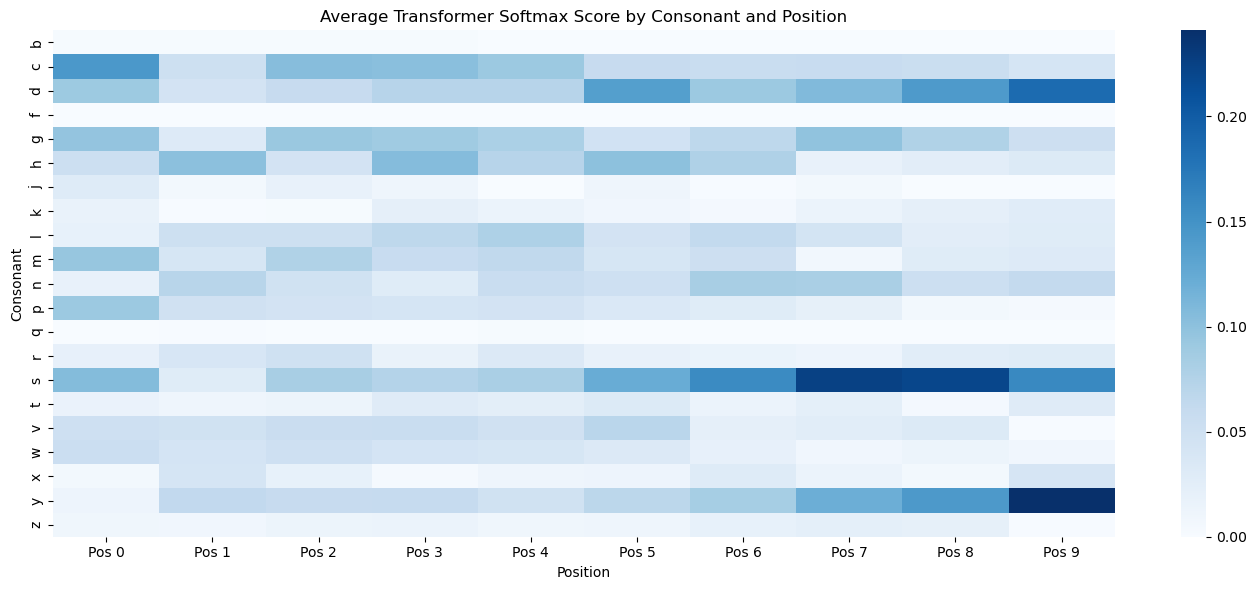

In [12]:
import json
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === CONFIG ===
log_path = utils.results_path("logs/v3_eval/transformer_best.jsonl")  # Update as needed
consonants = list("bcdfghjklmnpqrstvwxyz")

# === STEP 1: Load scores ===
position_score_totals = defaultdict(lambda: defaultdict(float))
position_score_counts = defaultdict(lambda: defaultdict(int))

with open(log_path, "r") as f:
    for line in f:
        record = json.loads(line)
        scores = record.get("consonant_scores", {})

        for pos_str, score_dict in scores.items():
            pos = int(pos_str)
            for letter, score in score_dict.items():
                position_score_totals[pos][letter] += score
                position_score_counts[pos][letter] += 1

# === STEP 2: Average scores ===
avg_scores = defaultdict(dict)
for pos in position_score_totals:
    for letter in position_score_totals[pos]:
        total = position_score_totals[pos][letter]
        count = position_score_counts[pos][letter]
        avg_scores[pos][letter] = total / max(count, 1)

# # === STEP 3: Convert to DataFrame ===
# df = pd.DataFrame(avg_scores).fillna(0)
# df = df.loc[consonants]  # Ensure consistent order
# df.columns = [f"Pos {i}" for i in df.columns]

# Ensure columns (positions) are sorted numerically
df = pd.DataFrame(avg_scores).fillna(0)
df = df.loc[consonants]  # Ensure consistent consonant order

# Sort columns numerically before relabeling
df = df[sorted(df.columns)]
df.columns = [f"Pos {i}" for i in df.columns]

# === STEP 4: Plot ===
plt.figure(figsize=(14, 6))
sns.heatmap(df, cmap="Blues")
plt.title("Average Transformer Softmax Score by Consonant and Position")
plt.xlabel("Position")
plt.ylabel("Consonant")
plt.tight_layout()
plt.show()
plt.savefig("heatmaps/transformer_softmax_score_heatmap.png")
plt.close()

